**Calling all necessary libraries**

In [ ]:
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
from sklearn.utils import class_weight
from scipy.signal import spectrogram
import tensorflow as tf
import random
import joblib
import matplotlib.image as mpimg

**Parameters defining**

In [ ]:
# Parameters
selected_movements = [1, 2, 3, 4, 6, 8]  # M1, M2, M3, M4, M6, M8
movement_to_index = {m: i for i, m in enumerate(selected_movements)}
movement_labels = ["Extension", "Flexion", "Ulnar Deviation", "Radial Deviation", "Power Grip", "Precision Grip"]
data_folder = "/content/drive/MyDrive/DSP_project/dataset/DIGITAL DATA"

num_participants = 28

num_cycles = 3
num_sensors = 4
num_forearms = 2
sampling_rate = 13000
window_size = 256
overlap = 128

b = 1 # signal with offset

**Necessary Functions**

In [ ]:
def manual_spectrogram(signal, fs=13000, nperseg=256, noverlap=128):
    step = int(nperseg - noverlap)
    n_windows = int((len(signal) - noverlap) // step)
    window = np.hanning(nperseg)

    Sxx = []
    times = []

    for i in range(n_windows):
        start = i * step
        end = start + nperseg
        segment = signal[start:end]

        if len(segment) < nperseg:
            break

        segment = segment * window
        fft_vals = np.fft.fft(segment)
        fft_freqs = np.fft.fftfreq(len(segment),1/fs)

        pos_mask = fft_freqs >= 0
        power = np.abs(fft_vals[pos_mask]) ** 2

        Sxx.append(power)
        times.append((start + end) / 2 / fs)

    Sxx = np.array(Sxx).T
    freqs = fft_freqs[pos_mask]

    return freqs, np.array(times), Sxx

**STFT Determination**

In [ ]:
def load_and_preprocess_spectrograms():
    X, Y = [], []

    for participant in range(1, num_participants + 1):
        for cycle in range(1, num_cycles + 1):
            for movement in selected_movements:
                for forearm in range(1, num_forearms + 1):
                    sensor_signals = []
                    for sensor in range(1, num_sensors + 1):
                        file_name = f"P{participant}C{cycle}S{sensor}M{movement}F{forearm}O{b}"
                        file_path = os.path.join(data_folder, file_name)

                        try:
                            signal = np.loadtxt(file_path, delimiter=',')[:sampling_rate]
                            f, t, Sxx = manual_spectrogram(signal)
                            sensor_signals.append(np.log1p(Sxx))  # log(1 + Sxx) for better contrast
                        except Exception as e:
                            print(f"Error loading {file_name}: {e}")
                            break

                    if len(sensor_signals) == num_sensors:
                        min_shape = np.min([s.shape for s in sensor_signals], axis=0)
                        resized = [s[:min_shape[0], :min_shape[1]] for s in sensor_signals]
                        stacked = np.stack(resized, axis=-1)  # Shape: (H, W, 4)

                        if stacked.shape[0] >= 96 and stacked.shape[1] >= 96:
                            clipped = stacked[:96, :96, :]
                            X.append(clipped)
                            Y.append(movement_to_index[movement])

    return np.array(X), np.array(Y)

**`Calculating STFT for the entire dataset **

In [ ]:
# Load and preprocess spectrograms

X,Y = load_and_preprocess_spectrograms()

**Preprocessing data before Train  Model**

In [ ]:
# Normalize per channel
means = [X[:, :, :, i].mean() for i in range(4)]
stds = [X[:, :, :, i].std() for i in range(4)]
for i in range(4):
    X[:, :, :, i] = (X[:, :, :, i] - means[i]) / stds[i]

# Flatten spectrograms for SVM input
X_flat = X.reshape(X.shape[0], -1)  # Shape: (N, 96*96*4)

# Train-test split
X_train_stft, X_test_stft, y_train_stft, y_test_stft = train_test_split(X_flat, Y, test_size=0.2, stratify=Y, random_state=42)

# Compute class weights
class_weights = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(Y), y=Y)
class_weights_dict = {i: w for i, w in enumerate(class_weights)}

**Using SVM Model**

Test Accuracy: 85.15%


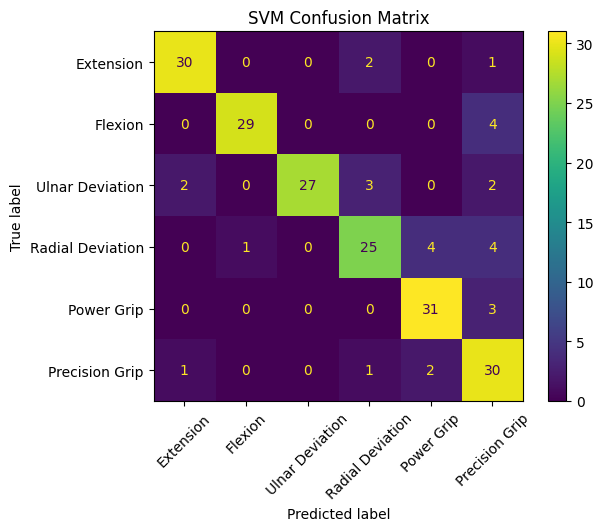

In [ ]:
# Train SVM
svm = SVC(kernel='rbf', class_weight=class_weights_dict, probability=True, random_state=42)
svm.fit(X_train_stft, y_train_stft)

# Predict and evaluate
y_pred_stft = svm.predict(X_test_stft)
accuracy = accuracy_score(y_test_stft, y_pred_stft)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

# Confusion matrix

cm = confusion_matrix(y_test_stft, y_pred_stft)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=movement_labels)
disp.plot(xticks_rotation=45)
plt.grid(False)
plt.title("SVM Confusion Matrix")
plt.show()

In [ ]:
# Save model
model_path = "/content/drive/MyDrive/DSP_project/svm_wyoflex_model.pkl"
joblib.dump(svm, model_path)
print(f"Model saved to {model_path}")


Model saved to /content/drive/MyDrive/DSP_project/svm_wyoflex_model.pkl


**Loading the model**

In [ ]:
model_path = "/content/drive/MyDrive/DSP_project/svm_wyoflex_model.pkl"
svm_loaded = joblib.load(model_path)
print(" Model loaded successfully")

 Model loaded successfully


**Showing Model Parameter**

In [ ]:
print(" Model loaded successfully")
print("\n Model Parameters:")
print(svm_loaded.get_params())

print("\n Support Vectors shape:", svm_loaded.support_vectors_.shape)
print(" Number of support vectors per class:", svm_loaded.n_support_)
print(" Dual coefficients shape:", svm_loaded.dual_coef_.shape)


 Model loaded successfully

 Model Parameters:
{'C': 1.0, 'break_ties': False, 'cache_size': 200, 'class_weight': {0: np.float64(1.0), 1: np.float64(1.0), 2: np.float64(1.0), 3: np.float64(1.0), 4: np.float64(1.0), 5: np.float64(1.0)}, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 'scale', 'kernel': 'rbf', 'max_iter': -1, 'probability': True, 'random_state': 42, 'shrinking': True, 'tol': 0.001, 'verbose': False}

 Support Vectors shape: (721, 36864)
 Number of support vectors per class: [ 99 107 127 131 126 131]
 Dual coefficients shape: (5, 721)


**Learning Curve for SVM**

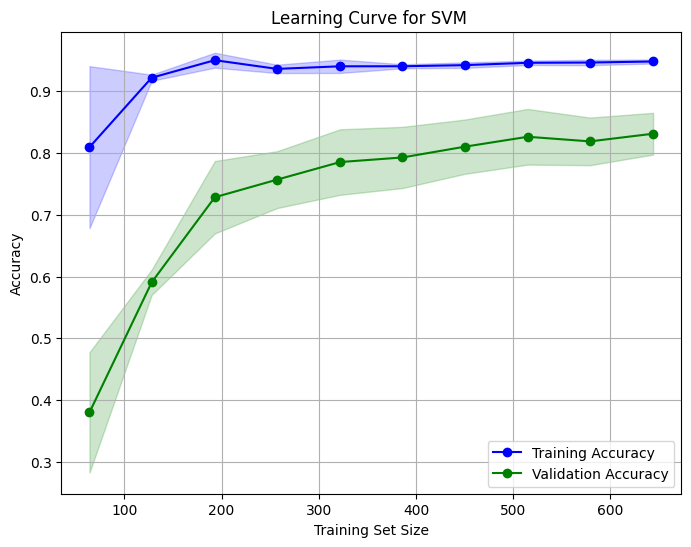

In [ ]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(
    svm_loaded, X_train_stft, y_train_stft, cv=5, scoring='accuracy',
    train_sizes=np.linspace(0.1, 1.0, 10), n_jobs=-1
)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.figure(figsize=(8, 6))
plt.plot(train_sizes, train_mean, 'o-', color='blue', label='Training Accuracy')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.2, color='blue')

plt.plot(train_sizes, test_mean, 'o-', color='green', label='Validation Accuracy')
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.2, color='green')

plt.title('Learning Curve for SVM ')
plt.xlabel('Training Set Size')
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.grid(True)
plt.show()


**Using Random Forest Model**


Test Accuracy: 80.69%


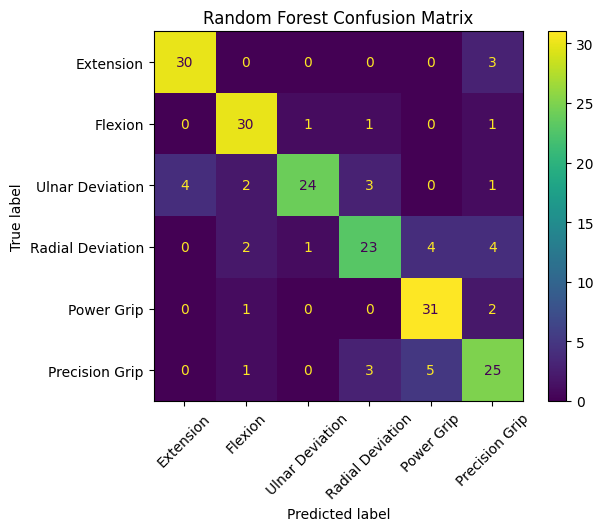

In [ ]:
clf = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)

clf.fit(X_train_stft, y_train_stft)
y_pred_stft = clf.predict(X_test_stft)
accuracy = accuracy_score(y_test_stft, y_pred_stft)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

# Compute confusion matrix
cm = confusion_matrix(y_test_stft, y_pred_stft)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=movement_labels)
disp.plot(xticks_rotation=45)
plt.grid(False)
plt.title("Random Forest Confusion Matrix")
plt.show()


In [ ]:

# Save random forest model
model_path = "/content/drive/MyDrive/DSP_project/rf_wyoflex_model.pkl"
joblib.dump(clf, model_path)
print(f" Model saved to {model_path}")


 Model saved to /content/drive/MyDrive/DSP_project/rf_wyoflex_model.pkl


***Using KNN Model***

In [ ]:
knn = KNeighborsClassifier(n_neighbors=7, weights='distance', metric='manhattan')

# Train
knn.fit(X_train_stft, y_train_stft)

y_pred_stft = knn.predict(X_test_stft)
accuracy = accuracy_score(y_test_stft, y_pred_stft)
print(f"Test Accuracy: {accuracy * 100:.2f}%")


Test Accuracy: 76.24%


In [ ]:
#saving KNN model
model_path = "/content/drive/MyDrive/DSP_project/knn_wyoflex_model.pkl"
joblib.dump(knn, model_path)
print(f" Model saved to {model_path}")

 Model saved to /content/drive/MyDrive/DSP_project/knn_wyoflex_model.pkl


# **Random Prediction**

In [ ]:
def predict_random_sample(model, person, cycle, movement, forearm, plot_3d=True):

    movement_names = {
        1: "Extension", 2: "Flexion", 3: "Ulnar Deviation", 4: "Radial Deviation",
        6: "Power Grip", 8: "Precision Grip"
          }
    while True:

        sensor_signals = []
        file_names = []

        for sensor in range(1, num_sensors + 1):
            file_name = f"P{person}C{cycle}S{sensor}M{movement}F{forearm}O{b}"
            file_path = os.path.join(data_folder, file_name)
            file_names.append(file_name)
            try:
                signal = np.loadtxt(file_path, delimiter=',')[:sampling_rate]
                f, t, Sxx = manual_spectrogram(signal)
                Sxx_log = np.log1p(Sxx)
                sensor_signals.append(Sxx_log)
            except Exception as e:
                print(f" Skipping {file_name} due to error: {e}")
                break

        if len(sensor_signals) == 4:
            min_shape = np.min([s.shape for s in sensor_signals], axis=0)
            resized = [s[:min_shape[0], :min_shape[1]] for s in sensor_signals]
            stacked = np.stack(resized, axis=-1)  # (H, W, 4)
            clipped = stacked[:96, :96, :]        # (96, 96, 4)

            #  Normalize using means and stds
            for i in range(4):
                clipped[:, :, i] = (clipped[:, :, i] - means[i]) / stds[i]

            #  Flatten for prediction
            X_flat = clipped.reshape(1, -1)

            #  Predict
            pred_index = model.predict(X_flat)[0]
            true_index = movement_to_index[movement]
            true_label = movement_labels[true_index]
            pred_label = movement_labels[pred_index]

            print("\n Loaded files:")
            for name in file_names:
                print(f"   - {name}")

            print(f"\n True movement: {true_label} (Class {true_index})")
            print(f" Predicted movement: {pred_label} (Class {pred_index})")

            # Raw signal plot
            plt.plot(signal)
            plt.title("Raw EMG Signal")
            plt.xlabel("Sample")
            plt.ylabel("Amplitude")
            plt.grid(True)

            # ===================== 🔹 Advanced Frequency Analysis 🔹 ===================== #
            # Remove DC offset
            signal2 = signal - np.mean(signal)
            # Apply window (optional)
            windowed_signal = signal2 * np.hamming(len(signal2))

            N = len(signal2)
            freqs = np.fft.fftfreq(N, d=1/sampling_rate)
            fft_values = np.fft.fft(windowed_signal)
            magnitude = np.abs(fft_values)
            phase = np.angle(fft_values)
            power = magnitude ** 2

            # Magnitude Spectrum
            plt.figure(figsize=(10, 4))
            plt.plot(freqs[:N // 2], magnitude[:N // 2])
            plt.title("Magnitude Spectrum")
            plt.xlabel("Frequency (Hz)")
            plt.ylabel("Magnitude")
            plt.grid(True)
            plt.show()

            # Phase Spectrum
            plt.figure(figsize=(10, 4))
            plt.plot(freqs[:N // 2], phase[:N // 2])
            plt.title("Phase Spectrum")
            plt.xlabel("Frequency (Hz)")
            plt.ylabel("Phase (radians)")
            plt.grid(True)
            plt.show()

            # Power Spectrum
            plt.figure(figsize=(10, 4))
            plt.plot(freqs[:N // 2], power[:N // 2])
            plt.title("Power Spectrum")
            plt.xlabel("Frequency (Hz)")
            plt.ylabel("Power")
            plt.grid(True)
            plt.show()

            # Histogram of raw signal
            plt.figure(figsize=(6, 4))
            plt.hist(signal2, bins=50, color='skyblue', edgecolor='black')
            plt.title("Histogram of Raw EMG Signal Amplitudes")
            plt.xlabel("Amplitude")
            plt.ylabel("Count")
            plt.grid(True)
            plt.show()

           #3D ploting
            from mpl_toolkits.mplot3d import Axes3D
            X, Y = np.meshgrid(t, f)

            ax = plt.figure().add_subplot(111, projection='3d')
            ax.plot_surface(X, Y, np.log1p(Sxx), cmap='viridis')
            plt.title("3D Spectrogram View")
            plt.xlabel("Time [s]")
            plt.ylabel("Frequency [Hz]")
            ax.set_zlabel("Log Power")
            plt.show()

            # Plot spectrogram of sensor 1 (channel 0)
            plt.figure(figsize=(10, 4))
            plt.pcolormesh(t[:min_shape[1]], f[:min_shape[0]], sensor_signals[0][:min_shape[0], :min_shape[1]], shading='gouraud')
            plt.ylabel('Frequency [Hz]')
            plt.xlabel('Time [s]')
            plt.title(f"Spectrogram of Sensor 1 - Movement: {movement_names[movement]}")
            plt.colorbar(label='Log Power')
            plt.tight_layout()
            plt.show()

            return


 Loaded files:
   - P25C3S1M1F2O1
   - P25C3S2M1F2O1
   - P25C3S3M1F2O1
   - P25C3S4M1F2O1

 True movement: Extension (Class 0)
 Predicted movement: Extension (Class 0)


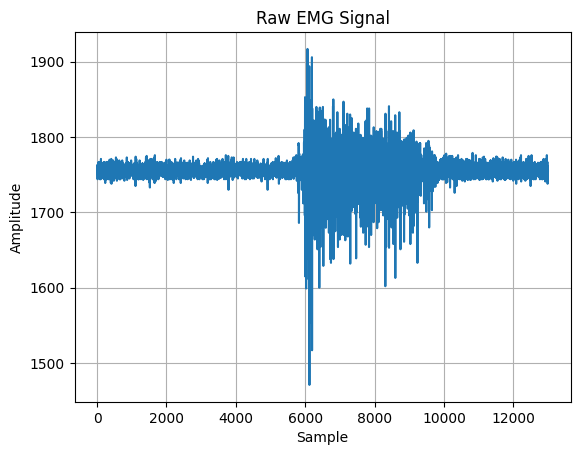

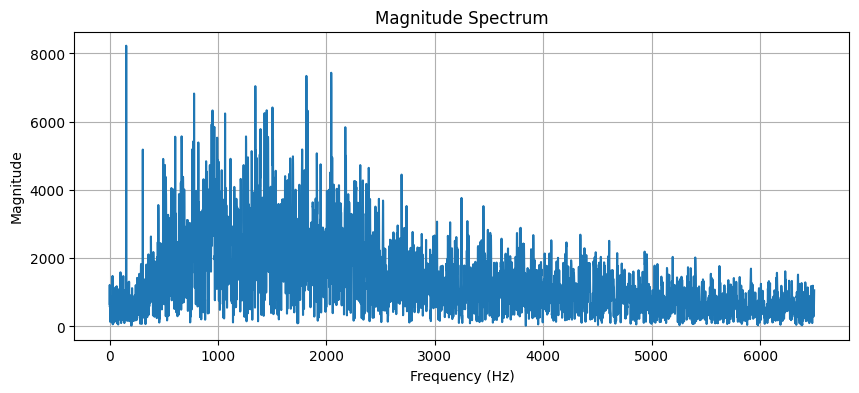

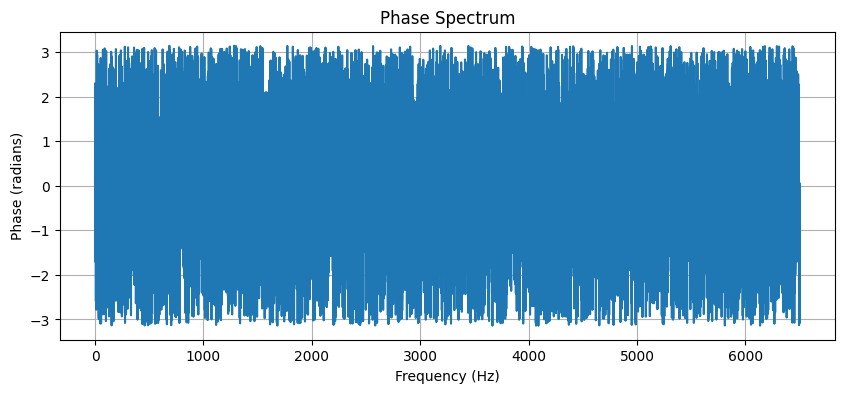

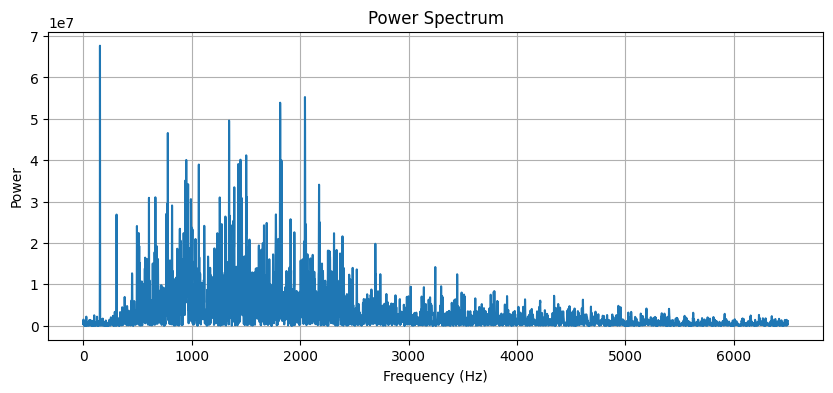

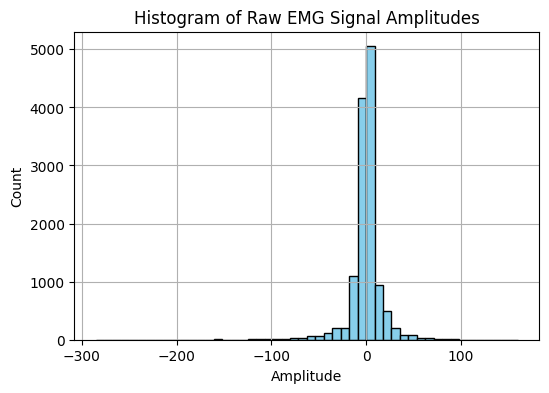

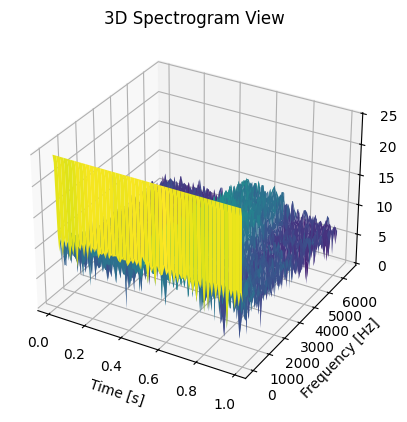

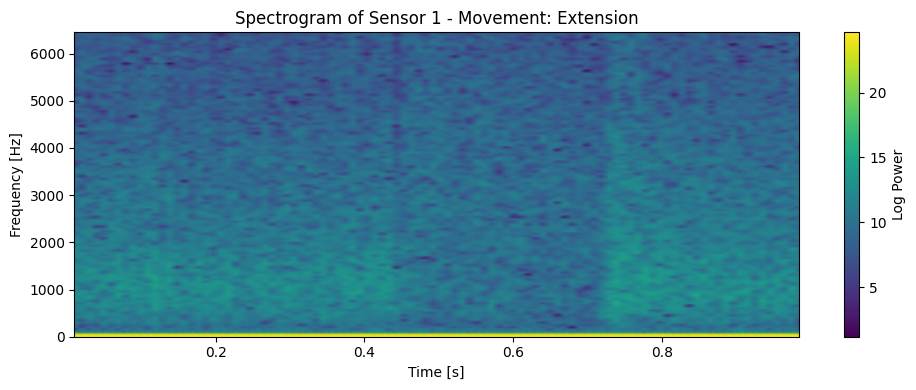

In [ ]:
person = random.randint(1, num_participants)
cycle = random.randint(1, num_cycles)
movement = random.choice(selected_movements)
forearm = random.randint(1, num_forearms)
result = predict_random_sample( model=svm, person=person, cycle=cycle, movement=movement, forearm=forearm,
    plot_3d=True
)

**Showing Each class Accuracy**

In [ ]:

def plot_per_class_accuracy(model, X_test_stft, y_test_stft, movement_labels):
    y_pred_stft = model.predict(X_test_stft)
    classes = np.unique(y_test_stft)
    accuracies = []

    for cls in classes:
        idx = y_test_stft == cls
        acc = np.mean(y_pred_stft[idx] == y_test_stft[idx])
        accuracies.append(acc * 100)

    plt.figure(figsize=(8, 5))
    plt.bar([movement_labels[cls] for cls in classes], accuracies, color='skyblue', edgecolor='black')
    plt.xlabel("Movement Class")
    plt.ylabel("Accuracy (%)")
    plt.title("Per-Class Accuracy on WyoFlex Test Set")
    plt.ylim(0, 100)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # Optionally return values for logging/reporting
    return dict(zip([movement_labels[cls] for cls in classes], accuracies))


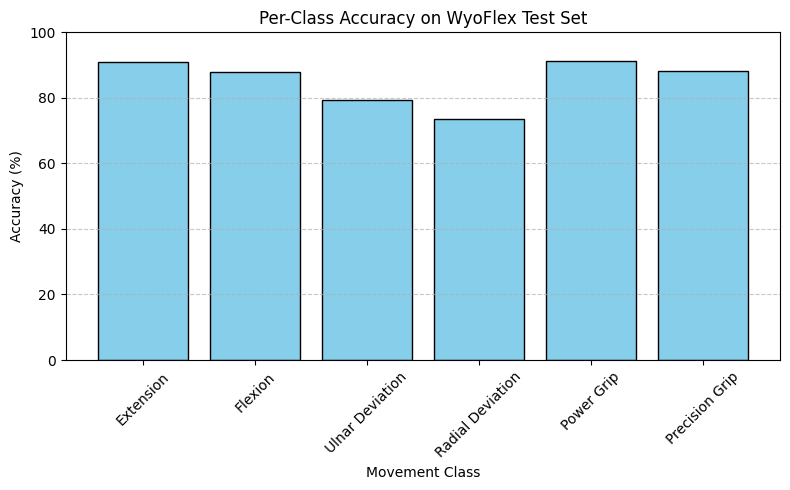

{'Extension': np.float64(90.9090909090909),
 'Flexion': np.float64(87.87878787878788),
 'Ulnar Deviation': np.float64(79.41176470588235),
 'Radial Deviation': np.float64(73.52941176470588),
 'Power Grip': np.float64(91.17647058823529),
 'Precision Grip': np.float64(88.23529411764706)}

In [ ]:
plot_per_class_accuracy(svm_loaded, X_test_stft, y_test_stft, movement_labels)

**prediction using user input**

Give the participant's no: 1
Give the cycle no: 1
Give the movement no: 2
Give the forearm no: 1

 Loaded files:
   - P1C1S1M2F1O1
   - P1C1S2M2F1O1
   - P1C1S3M2F1O1
   - P1C1S4M2F1O1

 True movement: Flexion (Class 1)
 Predicted movement: Flexion (Class 1)


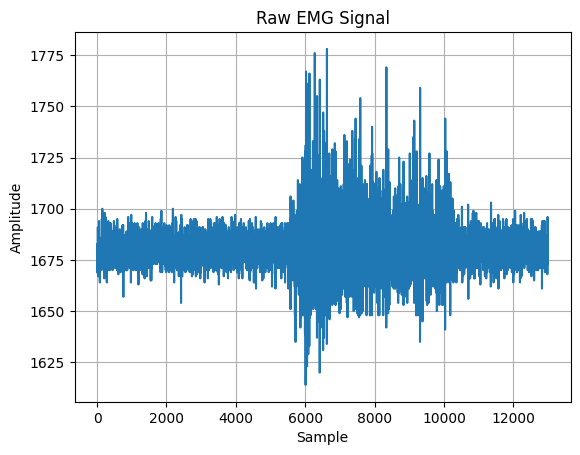

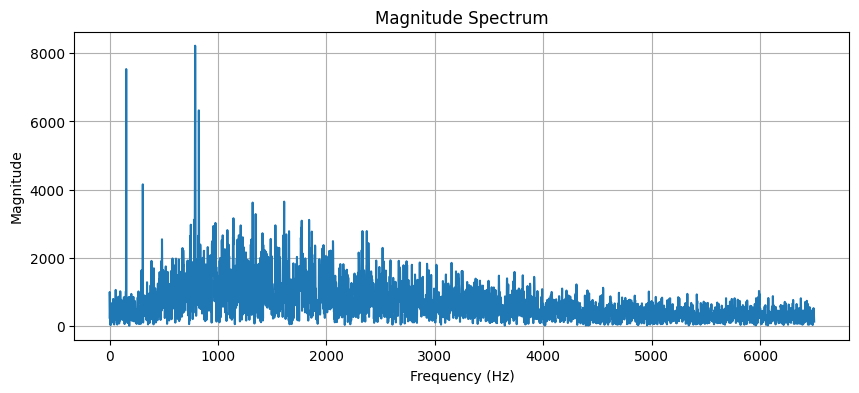

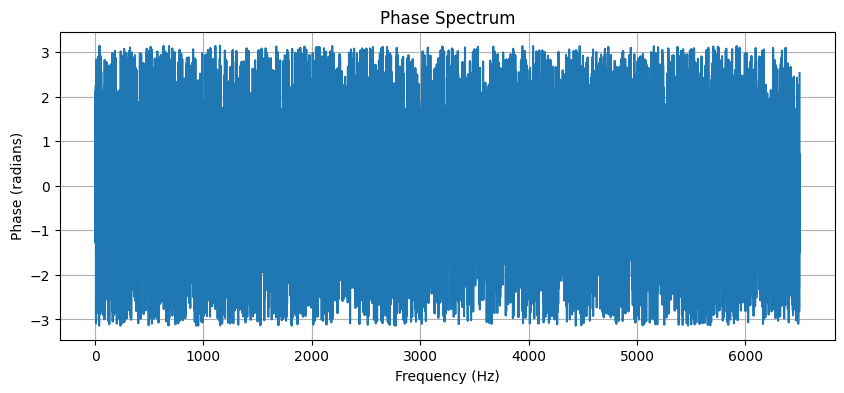

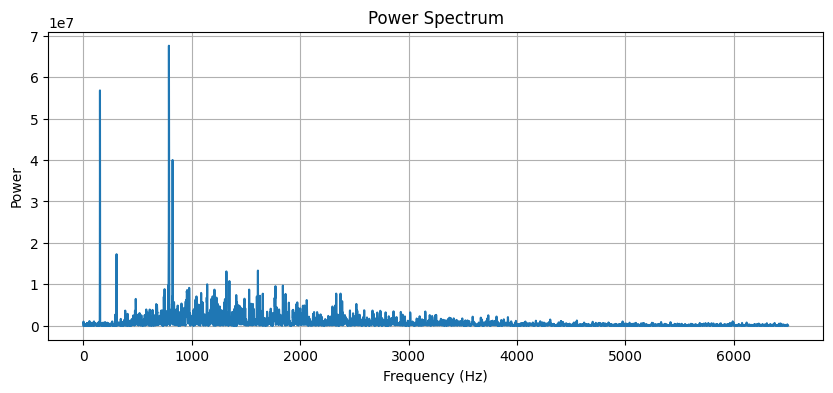

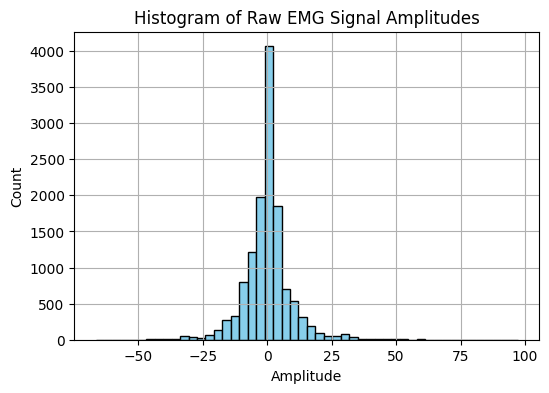

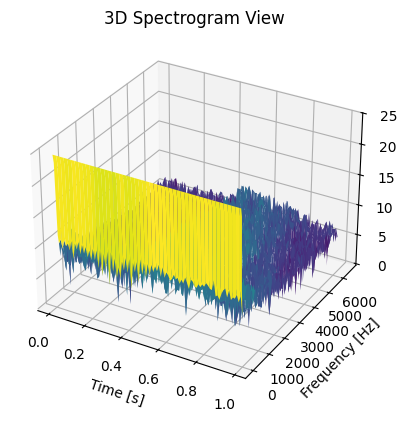

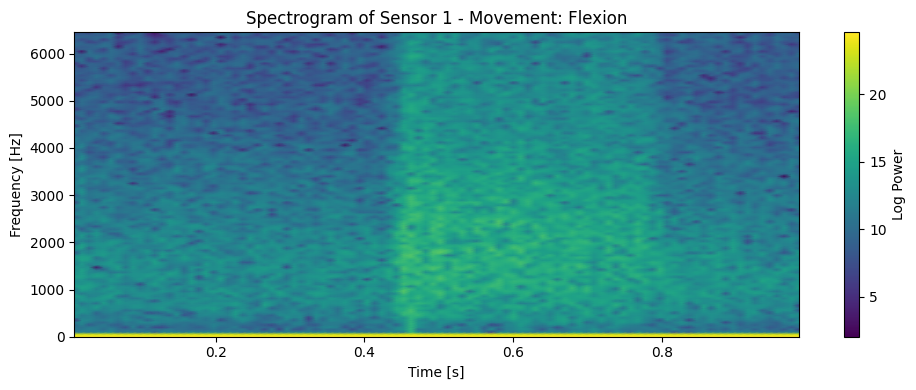

In [ ]:
person = input("Give the participant's no: ")
cycle = input("Give the cycle no: ")
movement_str = input("Give the movement no: ") # Read movement as string
forearm = input("Give the forearm no: ")
movement = int(movement_str)  # Convert to integer

predict_random_sample( model=svm_loaded, person=person, cycle=cycle, movement=movement, forearm=forearm,
plot_3d=True)

**Feature extraction with RMS, MAV, SSC, WAMP for each segment**

In [ ]:
def extract_emg_features_segmented(signal, n_segments=4, ssc_thresh=0.01, wamp_thresh=0.01):

    segment_length = len(signal) // n_segments
    features = []
    for i in range(n_segments):
        segment = signal[i * segment_length: (i + 1) * segment_length]
        # RMS
        rms = np.sqrt(np.mean(segment ** 2))
        # MAV
        mav = np.mean(np.abs(segment))
        # SSC
        diff = np.diff(segment)
        ssc = np.sum(((diff[:-1] * diff[1:]) < 0) &
                     (np.abs(diff[:-1] - diff[1:]) >= ssc_thresh))
        # WAMP
        wamp = np.sum(np.abs(diff) >= wamp_thresh)
        features.extend([rms, mav, ssc, wamp])
    return features  # length = n_segments * 4


 Loaded samples: 1008, feature size per sample: 64
 Test Accuracy with Segmented RMS, MAV, SSC, WAMP: 75.74%


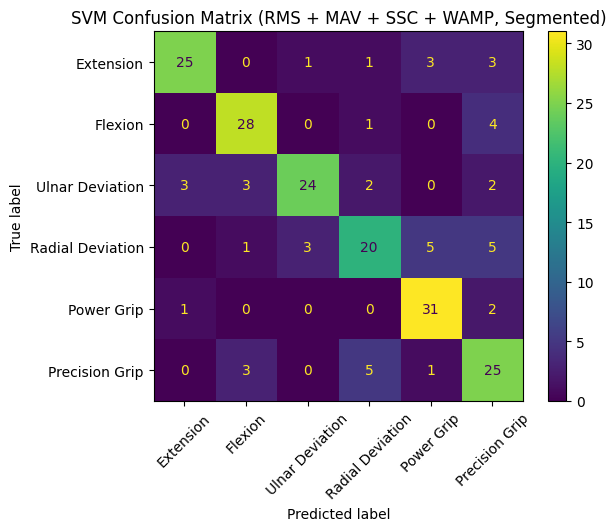

In [ ]:


#  Load dataset
X, Y = [], []

for participant in range(1, num_participants + 1):
    for cycle in range(1, num_cycles + 1):
        for movement in selected_movements:
            for forearm in range(1, num_forearms + 1):
                features = []
                valid = True
                for sensor in range(1, num_sensors + 1):
                    file_name = f"P{participant}C{cycle}S{sensor}M{movement}F{forearm}O{b}"
                    file_path = os.path.join(data_folder, file_name)
                    try:
                        signal = np.loadtxt(file_path, delimiter=',')[:sampling_rate]
                        sensor_features = extract_emg_features_segmented(signal, n_segments=4)
                        features.extend(sensor_features)
                    except Exception as e:
                        print(f"Error loading {file_name}: {e}")
                        valid = False
                        break
                if valid and len(features) == 64:
                    X.append(features)
                    Y.append(movement_to_index[movement])

X = np.array(X)  # Shape: (N, 64)
Y = np.array(Y)

print(f" Loaded samples: {X.shape[0]}, feature size per sample: {X.shape[1]}")

#  Normalize safely
X_mean = X.mean(axis=0)
X_std = X.std(axis=0)
X_std[X_std == 0] = 1
X = (X - X_mean) / X_std

#  Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, stratify=Y, random_state=42)

#  Compute class weights
class_weights = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(Y), y=Y)
class_weights_dict = {i: w for i, w in enumerate(class_weights)}

#  Train SVM
svm = SVC(kernel='rbf', class_weight=class_weights_dict, probability=True, random_state=42)
svm.fit(X_train, y_train)

#  Evaluate
y_pred = svm.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f" Test Accuracy with Segmented RMS, MAV, SSC, WAMP: {accuracy * 100:.2f}%")

#  Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=movement_labels)
disp.plot(xticks_rotation=45)
plt.grid(False)
plt.title("SVM Confusion Matrix (RMS + MAV + SSC + WAMP, Segmented)")
plt.show()


 Test Accuracy with Random Forest: 73.27%


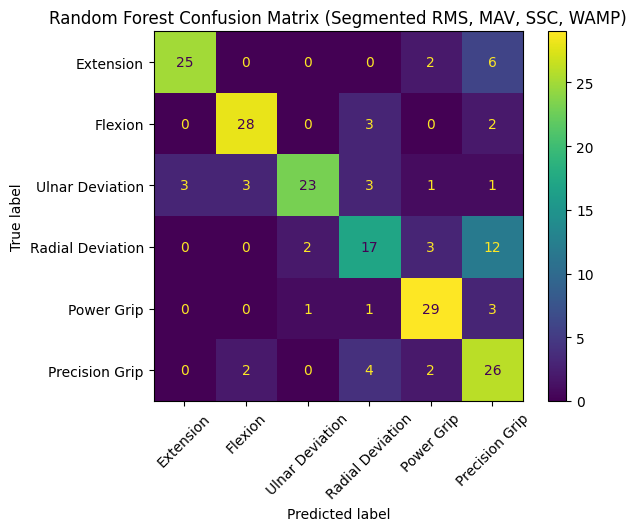

In [ ]:


#  Train Random Forest
rf = RandomForestClassifier(
    n_estimators=200,
    class_weight=class_weights_dict,
    random_state=42,
    n_jobs=-1,
    max_depth=None  # or tune if needed
)
rf.fit(X_train, y_train)

#  Evaluate
y_pred = rf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f" Test Accuracy with Random Forest: {accuracy * 100:.2f}%")

#  Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=movement_labels)
disp.plot(xticks_rotation=45)
plt.grid(False)
plt.title("Random Forest Confusion Matrix (Segmented RMS, MAV, SSC, WAMP)")
plt.show()
